In [17]:
import pandas as pd
import numpy as np
from pybaseball import statcast
from pybaseball import pitching_stats
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from unidecode import unidecode
import datetime as dt
import requests
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
"""
data20_23 = statcast(start_dt = "2020-04-01", end_dt = "2023-12-01") 
data20_23.to_csv('Statcast_2020_to_2023.csv')
"""

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates


  0%|          | 0/835 [00:00<?, ?it/s]/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  0%|          | 1/835 [00:05<1:10:14,  5.05s/it]/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  0%|          | 2/835 [00:11<1:18:00,  5.62s/it]/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/datahelpers/postpr

In [19]:
#Read in data
data20_23 = pd.read_csv("Statcast_2023.csv")
data24 = statcast("2024-03-28", "2024-06-13")

This is a large query, it may take a moment to complete


 95%|█████████▍| 74/78 [00:24<00:01,  3.67it/s]/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
100%|██████████| 78/78 [00:26<00:00,  2.94it/s]


In [20]:
data20_20__20_23['player_name'] = data20_20__20_23['player_name'].apply(unidecode)
data24['player_name'] = data20_20__20_23['player_name'].apply(unidecode)

In [21]:
#Select columns
data20_23 = data20_23[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','delta_run_exp']]
data24 = data24[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','delta_run_exp']]

In [22]:
#Drop na values
data20_23 = data20_23.dropna()
data24 = data24.dropna()

In [23]:
#Flip to get view from pitcher
data20_20__20_23['pfx_x'] = data20_20__20_23['pfx_x'] * -1
data24['pfx_x'] = data24['pfx_x'] * -1

#Change to inches
data20_20__20_23['pfx_x'] = data20_20__20_23['pfx_x'] * 12
data20_20__20_23['pfx_z'] = data20_20__20_23['pfx_z'] * 12
data24['pfx_x'] = data24['pfx_x'] * 12
data24['pfx_z'] = data24['pfx_z'] * 12

In [24]:
#Remove unnecessary pitches
data20_23 = data20_23[data20_23.pitch_type != 'PO']
data24 = data24[data24.pitch_type != 'PO']

In [25]:
#Retag pitches
data20_20__20_23['pitch_type'] = data20_20__20_23['pitch_type'].replace(['FF','FA'], 'Fastball')
data24['pitch_type'] = data24['pitch_type'].replace(['FF','FA'], 'Fastball')

data20_20__20_23['pitch_type'] = data20_20__20_23['pitch_type'].replace(['SI'], 'Sinker')
data24['pitch_type'] = data24['pitch_type'].replace(['SI'], 'Sinker')

data20_20__20_23['pitch_type'] = data20_20__20_23['pitch_type'].replace(['FC'], 'Cutter')
data24['pitch_type'] = data24['pitch_type'].replace(['FC'], 'Cutter')

data20_20__20_23['pitch_type'] = data20_20__20_23['pitch_type'].replace(['SL'], 'Slider')
data24['pitch_type'] = data24['pitch_type'].replace(['SL'], 'Slider')

data20_20__20_23['pitch_type'] = data20_20__20_23['pitch_type'].replace(['ST'], 'Sweeper')
data24['pitch_type'] = data24['pitch_type'].replace(['ST'], 'Sweeper')

data20_20__20_23['pitch_type'] = data20_20__20_23['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')
data24['pitch_type'] = data24['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')

data20_20__20_23['pitch_type'] = data20_20__20_23['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')
data24['pitch_type'] = data24['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')

data20_20__20_23['pitch_type'] = data20_20__20_23['pitch_type'].replace(['FS'], 'Splitter')
data24['pitch_type'] = data24['pitch_type'].replace(['FS'], 'Splitter')




In [26]:
#caculate vaa and haa
def approach_angles(df):
    yf = 17/12
    y0 = 50
    df['vy_f'] = -np.sqrt(df['vy0']**2 - (2 * df['ay'] * y0 - yf))
    df['t'] = (df['vy_f'] - df['vy0']) / df['ay']
    df['vz_f'] = df['vz0'] + (df['az'] * df['t'])
    df['vx_f'] = df['vx0'] + (df['ax'] * df['t'])

    df['vaa'] = -np.arctan(df['vz_f'] / df['vy_f']) * (180 / np.pi)
    df['haa'] = -np.arctan(df['vx_f'] / df['vy_f']) * (180 / np.pi)
    return df

data20_23 = approach_angles(data20_20_23)
data24 = approach_angles(data24)

#caculate estimated axis differential and estimated spin efficiency
def axis_differential(df):
    df['inferred_spin_degree'] = np.arctan2(df['pfx_z'],df['pfx_x']) * (180 / np.pi) #FROM ALAN NATHAN MOVEMENT CACULATOR V2
    df['axis_dif'] = np.abs(df['inferred_spin_degree'] - df['spin_axis'])
    return df

data20_23 = axis_differential(data20_20_23)
data24 = axis_differential(data24)

def find_most_common_fastball(df):
    #fastball_types = df[df['pitch_type'].isin(['Fastball', 'Sinker', 'Cutter','Slider','Sweeper','Curveball','Changeup','Splitter'])]
    fastball_types = df[df['pitch_type'].isin(['Fastball', 'Sinker', 'Cutter'])]
    most_common_fastball = fastball_types.groupby(['player_name', 'pitch_type']).size().reset_index(name='count')
    most_common_fastball = most_common_fastball.loc[most_common_fastball.groupby('player_name')['count'].idxmax()]
    most_common_fastball = most_common_fastball[['player_name', 'pitch_type']]
    most_common_fastball.rename(columns={'pitch_type': 'most_common_fastball'}, inplace=True)
    return most_common_fastball

def add_velocity_and_movement_diff(df):
    most_common_fastball = find_most_common_fastball(df)
    
    df = df.merge(most_common_fastball, on='player_name', how='left')
    
    avg_stats = df[df['pitch_type'] == df['most_common_fastball']].groupby('player_name')[['release_speed', 'pfx_x', 'pfx_z']].mean().reset_index()
    avg_stats.rename(columns={
        'release_speed': 'avg_fastball_velocity',
        'pfx_x': 'avg_fastball_pfx_x',
        'pfx_z': 'avg_fastball_pfx_z'
    }, inplace=True)
    
    df = df.merge(avg_stats, on='player_name', how='left')
    
    df['velocity_diff'] = df['avg_fastball_velocity'] - df['release_speed']
    df['horizontal_movement_diff'] = df['avg_fastball_pfx_x'] - df['pfx_x']
    df['vertical_movement_diff'] = df['avg_fastball_pfx_z'] - df['pfx_z']
    
    return df

data20_23 = add_velocity_and_movement_diff(data20_20_23)
data24 = add_velocity_and_movement_diff(data24)

In [27]:
#Seperate pitches for different models
fastball_20_23 = data20_23[data20_23.pitch_type.isin(['Fastball'])]
fastball_24 = data24[data24.pitch_type.isin(['Fastball'])]

sinker_20_23 = data20_23[data20_23.pitch_type.isin(['Sinker'])]
sinker_24 = data24[data24.pitch_type.isin(['Sinker'])]

cutter_20_23 = data20_23[data20_23.pitch_type.isin(['Cutter'])]
cutter_24 = data24[data24.pitch_type.isin(['Cutter'])]

slider_20_23 = data20_23[data20_23.pitch_type.isin(['Slider'])]
slider_24 = data24[data24.pitch_type.isin(['Slider'])]

sweeper_20_23 = data20_23[data20_23.pitch_type.isin(['Sweeper'])]
sweeper_24 = data24[data24.pitch_type.isin(['Sweeper'])]

curveball_20_23 = data20_23[data20_23.pitch_type.isin(['Curveball'])]
curveball_24 = data24[data24.pitch_type.isin(['Curveball'])]

changeup_20_23 = data20_23[data20_23.pitch_type.isin(['Changeup'])]
changeup_24 = data24[data24.pitch_type.isin(['Changeup'])]

splitter_20_23 = data20_23[data20_23.pitch_type.isin(['Splitter'])]
splitter_24 = data24[data24.pitch_type.isin(['Splitter'])]

In [28]:
features = ['release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z','game_year', 'axis_dif', 'velocity_diff', 'horizontal_movement_diff', 'vertical_movement_diff']

In [30]:
#Split into train and test

fastball_x = fastball_20_23[features]
fastball_y = fastball_20__20_23['delta_run_exp']

x_train_fastball, x_test_fastball, y_train_fastball, y_test_fastball = train_test_split(fastball_x, fastball_y, train_size = 0.75, random_state = 12345)

sinker_x = sinker_20_23[features]
sinker_y = sinker_20__20_23['delta_run_exp']

x_train_sinker, x_test_sinker, y_train_sinker, y_test_sinker = train_test_split(sinker_x, sinker_y, train_size=0.75, random_state=12345)

cutter_x = cutter_20_23[features]
cutter_y = cutter_20__20_23['delta_run_exp']

x_train_cutter, x_test_cutter, y_train_cutter, y_test_cutter = train_test_split(cutter_x, cutter_y, train_size=0.75, random_state=12345)

slider_x = slider_20_23[features]
slider_y = slider_20__20_23['delta_run_exp']

x_train_slider, x_test_slider, y_train_slider, y_test_slider = train_test_split(slider_x, slider_y, train_size=0.75, random_state=12345)

sweeper_x = sweeper_20_23[features]
sweeper_y = sweeper_20__20_23['delta_run_exp']

x_train_sweeper, x_test_sweeper, y_train_sweeper, y_test_sweeper = train_test_split(sweeper_x, sweeper_y, train_size=0.75, random_state=12345)

curveball_x = curveball_20_23[features]
curveball_y = curveball_20__20_23['delta_run_exp']

x_train_curveball, x_test_curveball, y_train_curveball, y_test_curveball = train_test_split(curveball_x, curveball_y, train_size=0.75, random_state=12345)

changeup_x = changeup_20_23[features]
changeup_y = changeup_20__20_23['delta_run_exp']

x_train_changeup, x_test_changeup, y_train_changeup, y_test_changeup = train_test_split(changeup_x, changeup_y, train_size=0.75, random_state=12345)

splitter_x = splitter_20_23[features]
splitter_y = splitter_20__20_23['delta_run_exp']

x_train_splitter, x_test_splitter, y_train_splitter, y_test_splitter = train_test_split(splitter_x, splitter_y, train_size=0.75, random_state=12345)

In [31]:
#Set params for catboost models (Random ones right now)
params = {
    'iterations': 500,
    'depth': 5,
    'learning_rate': 0.11, #manual checks with FIP corr both predictive and descriptive
    'random_seed': 12345
    
}

#Train each model

#Fastball
fastball_model = CatBoostRegressor(**params)
fastball_model.fit(x_train_fastball, y_train_fastball)

#Sinker
sinker_model = CatBoostRegressor(**params)
sinker_model.fit(x_train_sinker, y_train_sinker)

#Cutter
cutter_model = CatBoostRegressor(**params)
cutter_model.fit(x_train_cutter, y_train_cutter)

#Slider
slider_model = CatBoostRegressor(**params)
slider_model.fit(x_train_slider, y_train_slider)

#Sweeper
sweeper_model = CatBoostRegressor(**params)
sweeper_model.fit(x_train_sweeper, y_train_sweeper)

#Curveball
curveball_model = CatBoostRegressor(**params)
curveball_model.fit(x_train_curveball, y_train_curveball)

#Changeup
changeup_model = CatBoostRegressor(**params)
changeup_model.fit(x_train_changeup, y_train_changeup)

#Splitter
splitter_model = CatBoostRegressor(**params)
splitter_model.fit(x_train_splitter, y_train_splitter)



0:	learn: 0.2446866	total: 6.54ms	remaining: 3.26s
1:	learn: 0.2446600	total: 11.7ms	remaining: 2.9s
2:	learn: 0.2446311	total: 16.9ms	remaining: 2.8s
3:	learn: 0.2446049	total: 21.8ms	remaining: 2.7s
4:	learn: 0.2445809	total: 26.3ms	remaining: 2.6s
5:	learn: 0.2445588	total: 31.6ms	remaining: 2.6s
6:	learn: 0.2445356	total: 36.1ms	remaining: 2.54s
7:	learn: 0.2445176	total: 40.6ms	remaining: 2.5s
8:	learn: 0.2444947	total: 45.2ms	remaining: 2.46s
9:	learn: 0.2444786	total: 49.9ms	remaining: 2.44s
10:	learn: 0.2444666	total: 54.4ms	remaining: 2.42s
11:	learn: 0.2444550	total: 59.1ms	remaining: 2.4s
12:	learn: 0.2444374	total: 63.8ms	remaining: 2.39s
13:	learn: 0.2444272	total: 68.4ms	remaining: 2.37s
14:	learn: 0.2444124	total: 73.2ms	remaining: 2.37s
15:	learn: 0.2444003	total: 77.9ms	remaining: 2.36s
16:	learn: 0.2443925	total: 83.5ms	remaining: 2.37s
17:	learn: 0.2443798	total: 87.9ms	remaining: 2.35s
18:	learn: 0.2443739	total: 92.4ms	remaining: 2.34s
19:	learn: 0.2443559	total: 9

In [32]:
#Predictions
fastball_20_23['pred'] = fastball_model.predict(fastball_20_23[features])

sinker_20_23['pred'] = sinker_model.predict(sinker_20_23[features])

cutter_20_23['pred'] = cutter_model.predict(cutter_20_23[features])

slider_20_23['pred'] = slider_model.predict(slider_20_23[features])

sweeper_20_23['pred'] = sweeper_model.predict(sweeper_20_23[features])

curveball_20_23['pred'] = curveball_model.predict(curveball_20_23[features])

changeup_20_23['pred'] = changeup_model.predict(changeup_20_23[features])

splitter_20_23['pred'] = splitter_model.predict(splitter_20_23[features])

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_66172/4021332879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_20_23['pred'] = fastball_model.predict(fastball_20_23[features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_66172/4021332879.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sinker_20_23['pred'] = sinker_model.predict(sinker_20_23[features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_66172/4021332879.py:6: SettingWithCopyWarning: 
A value

In [33]:
def scale_and_score(df):
    df['scaled'] = df['pred'] - df['pred'].max()
    df['scaled'] = abs(df['scaled'])
    df['scaled'] = df['scaled'] - df['scaled'].mean()
    df['scaled'] = df['scaled'] / df['scaled'].std()
    df['score'] = df['scaled'] * 10 + 100
    return df

scale_and_score(fastball_20_23)
scale_and_score(sinker_20_23)
scale_and_score(cutter_20_23)
scale_and_score(slider_20_23)
scale_and_score(sweeper_20_23)
scale_and_score(curveball_20_23)
scale_and_score(changeup_20_23)
scale_and_score(splitter_20_23)

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_66172/2944248080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaled'] = df['pred'] - df['pred'].max()
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_66172/2944248080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaled'] = abs(df['scaled'])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_66172/2944248080.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,player_name,pitch_type,release_speed,release_pos_x,release_pos_z,release_spin_rate,release_extension,spin_axis,pfx_x,pfx_z,...,most_common_fastball,avg_fastball_velocity,avg_fastball_pfx_x,avg_fastball_pfx_z,velocity_diff,horizontal_movement_diff,vertical_movement_diff,pred,scaled,score
106,"Eovaldi, Nathan",Splitter,87.3,-2.61,5.49,1498.0,6.7,240.0,10.32,1.32,...,Fastball,95.189638,12.576188,13.535718,7.889638,2.256188,12.215718,-0.025238,0.391253,103.912528
107,"Eovaldi, Nathan",Splitter,88.6,-2.39,5.61,1638.0,6.7,237.0,11.04,2.88,...,Fastball,95.189638,12.576188,13.535718,6.589638,1.536188,10.655718,0.003815,-0.127102,98.728977
108,"Eovaldi, Nathan",Splitter,85.6,-2.38,5.64,1574.0,6.7,241.0,12.00,2.04,...,Fastball,95.189638,12.576188,13.535718,9.589638,0.576188,11.495718,-0.019712,0.292665,102.926649
109,"Eovaldi, Nathan",Splitter,88.5,-2.51,5.51,1634.0,6.7,236.0,12.96,1.56,...,Fastball,95.189638,12.576188,13.535718,6.689638,-0.383812,11.975718,-0.008912,0.099968,100.999677
112,"Eovaldi, Nathan",Splitter,88.0,-2.52,5.55,1492.0,6.5,242.0,13.56,1.80,...,Fastball,95.189638,12.576188,13.535718,7.189638,-0.983812,11.735718,-0.022664,0.345329,103.453288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719181,"Gilbert, Logan",Splitter,84.5,-1.34,6.04,1055.0,7.5,232.0,11.16,3.48,...,Fastball,95.685094,6.130123,17.003145,11.185094,-5.029877,13.523145,-0.052186,0.872058,108.720579
719183,"Gilbert, Logan",Splitter,86.0,-1.39,6.02,754.0,7.4,242.0,10.44,6.00,...,Fastball,95.685094,6.130123,17.003145,9.685094,-4.309877,11.003145,-0.030743,0.489471,104.894711
719184,"Gilbert, Logan",Splitter,85.8,-1.37,6.17,1055.0,7.3,225.0,14.76,1.92,...,Fastball,95.685094,6.130123,17.003145,9.885094,-8.629877,15.083145,-0.059710,1.006290,110.062903
719217,"Gilbert, Logan",Splitter,87.3,-1.30,6.08,1219.0,7.6,222.0,10.68,2.76,...,Fastball,95.685094,6.130123,17.003145,8.385094,-4.549877,14.243145,-0.064287,1.087951,110.879506


In [34]:
def calculate_mean_scores(df):
    mean_scores = df.groupby('player_name')['score'].mean().reset_index()
    mean_scores.rename(columns={'score': 'mean_scores'}, inplace=True)
    mean_scores = mean_scores.sort_values(by='mean_scores', ascending=False)
    mean_scores['mean_scores'] = mean_scores['mean_scores'].round(2)
    return mean_scores

mean_scores_fastball = calculate_mean_scores(fastball_20_23)
mean_scores_sinker = calculate_mean_scores(sinker_20_23)
mean_scores_cutter = calculate_mean_scores(cutter_20_23)
mean_scores_slider = calculate_mean_scores(slider_20_23)
mean_scores_sweeper = calculate_mean_scores(sweeper_20_23)
mean_scores_curveball = calculate_mean_scores(curveball_20_23)
mean_scores_changeup = calculate_mean_scores(changeup_20_23)
mean_scores_splitter = calculate_mean_scores(splitter_20_23)


combined_scores = mean_scores_fastball
combined_scores = combined_scores.merge(mean_scores_sinker, how = 'outer', on = 'player_name', suffixes=('','_sinker'))
combined_scores = combined_scores.merge(mean_scores_cutter, how = 'outer', on = 'player_name', suffixes=('','_cutter'))
combined_scores = combined_scores.merge(mean_scores_slider, how = 'outer', on = 'player_name', suffixes=('','_slider'))
combined_scores = combined_scores.merge(mean_scores_sweeper, how = 'outer', on = 'player_name', suffixes=('','_sweeper'))
combined_scores = combined_scores.merge(mean_scores_curveball, how = 'outer', on = 'player_name', suffixes=('','_curveball'))
combined_scores = combined_scores.merge(mean_scores_changeup, how = 'outer', on = 'player_name', suffixes=('','_changeup'))
combined_scores = combined_scores.merge(mean_scores_splitter, how = 'outer', on = 'player_name', suffixes=('','_splitter'))



combined_scores = combined_scores.rename(columns = {
    'mean_scores': 'fastball',
    'mean_scores_sinker': 'sinker',
    'mean_scores_cutter': 'cutter',
    'mean_scores_slider': 'slider',
    'mean_scores_sweeper': 'sweeper',
    'mean_scores_curveball': 'curveball',
    'mean_scores_changeup': 'changeup',
    'mean_scores_splitter': 'splitter'
    }
)

In [35]:
pitch_counts = data20_23.groupby(['player_name', 'pitch_type']).size().unstack(fill_value=0).reset_index()

combined_data = combined_scores.merge(pitch_counts, how='outer', on='player_name')
combined_data.fillna(0, inplace=True)

combined_data['weighted_fastball'] = combined_data['fastball'] * combined_data['Fastball']
combined_data['weighted_sinker'] = combined_data['sinker'] * combined_data['Sinker']
combined_data['weighted_cutter'] = combined_data['cutter'] * combined_data['Cutter']
combined_data['weighted_slider'] = combined_data['slider'] * combined_data['Slider']
combined_data['weighted_sweeper'] = combined_data['sweeper'] * combined_data['Sweeper']
combined_data['weighted_curveball'] = combined_data['curveball'] * combined_data['Curveball']
combined_data['weighted_changeup'] = combined_data['changeup'] * combined_data['Changeup']
combined_data['weighted_splitter'] = combined_data['splitter'] * combined_data['Splitter']

combined_data['total_weighted_score'] = (
    combined_data['weighted_fastball'] +
    combined_data['weighted_sinker'] +
    combined_data['weighted_cutter'] +
    combined_data['weighted_slider'] +
    combined_data['weighted_sweeper'] +
    combined_data['weighted_curveball'] +
    combined_data['weighted_changeup'] +
    combined_data['weighted_splitter']
)

combined_data['total_pitches'] = (
    combined_data['Fastball'] +
    combined_data['Sinker'] +
    combined_data['Cutter'] +
    combined_data['Slider'] +
    combined_data['Sweeper'] +
    combined_data['Curveball'] +
    combined_data['Changeup'] +
    combined_data['Splitter']
)

combined_data['overall'] = combined_data['total_weighted_score'] / combined_data['total_pitches']
combined_data['overall'] = combined_data['overall'].round(2)

min_pitch_count = 50
combined_data = combined_data[combined_data['total_pitches'] >= min_pitch_count]

combined_data = combined_data[['player_name', 'overall', 'fastball', 'sinker', 'cutter', 'slider', 'sweeper', 'curveball', 'changeup', 'splitter']]
combined_data = combined_data.sort_values(by='overall', ascending=False)

combined_data.to_csv("testing_23train.csv", index=False)
combined_data

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
49,"Bautista, Felix",108.75,110.18,0.00,0.00,102.27,0.00,0.00,0.00,105.92
654,"Romano, Jordan",108.28,107.76,70.93,0.00,108.88,0.00,0.00,0.00,0.00
682,"Scott, Tanner",108.06,106.11,0.00,0.00,109.83,0.00,0.00,0.00,0.00
20,"Alvarado, Jose",106.47,0.00,108.74,103.14,0.00,0.00,0.00,0.00,0.00
218,"Fairbanks, Pete",106.16,103.32,0.00,0.00,108.86,0.00,0.00,112.68,0.00
...,...,...,...,...,...,...,...,...,...,...
409,"Krook, Matt",81.96,0.00,76.12,82.05,0.00,104.25,0.00,98.61,0.00
694,"Short, Zack",73.72,65.70,0.00,0.00,0.00,0.00,85.59,96.65,0.00
379,"Kelly, Carson",67.76,67.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00
463,"Maile, Luke",66.95,67.27,0.00,0.00,0.00,0.00,0.00,58.83,0.00


In [46]:
combined_data.sort_values(by='splitter', ascending=False).head(30)

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
475,"Martin, Chris",106.05,105.24,103.99,107.22,92.76,101.89,0.00,0.00,110.91
388,"Kerr, Ray",100.03,98.49,0.00,0.00,0.00,0.00,101.00,0.00,106.94
49,"Bautista, Felix",108.75,110.18,0.00,0.00,102.27,0.00,0.00,0.00,105.92
505,"Megill, Tylor",100.36,99.36,0.00,0.00,102.08,0.00,101.10,101.23,105.78
327,"Hicks, Jordan",105.57,100.66,109.30,0.00,101.52,97.02,0.00,0.00,105.62
727,"Stephenson, Robert",103.36,103.25,0.00,105.80,98.50,0.00,99.26,0.00,105.42
203,"Duran, Jhoan",104.71,103.26,0.00,0.00,0.00,0.00,106.87,0.00,104.91
745,"Swanson, Erik",101.77,98.21,0.00,0.00,101.28,0.00,0.00,0.00,104.53
389,"Kershaw, Clayton",102.92,100.28,101.31,0.00,105.21,0.00,103.38,97.00,104.47
808,"Watkins, Spenser",95.30,100.47,94.48,94.73,89.08,0.00,92.67,0.00,104.46


In [45]:
mean_data = combined_data['splitter']
mean_data = mean_data[mean_data !=0]
mean_data.mean()

98.95057471264364

In [37]:
my_value = 'Gilbert, Logan'
results = combined_data.loc[combined_data["player_name"] == my_value]
results

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
263,"Gilbert, Logan",101.93,97.44,95.08,0.0,108.88,0.0,101.86,0.0,100.88


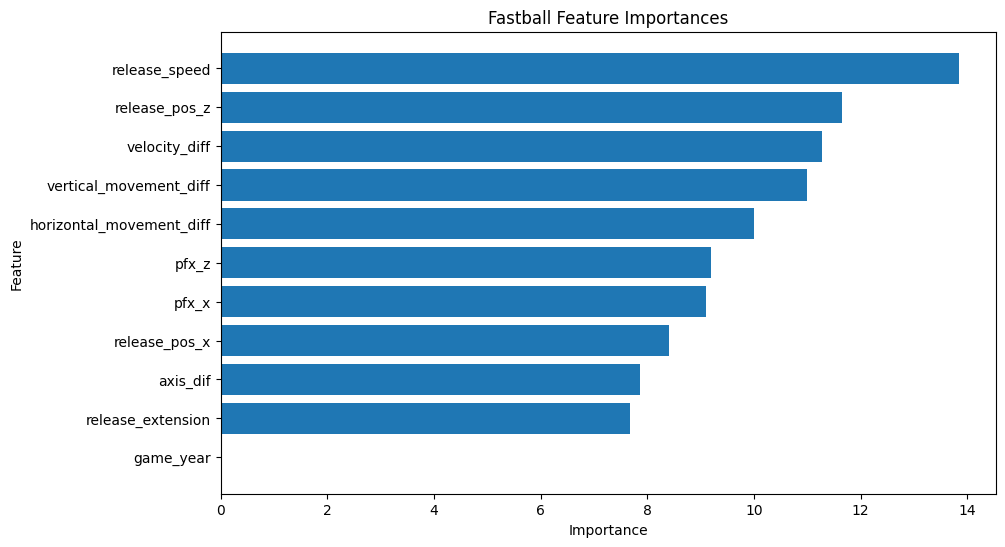

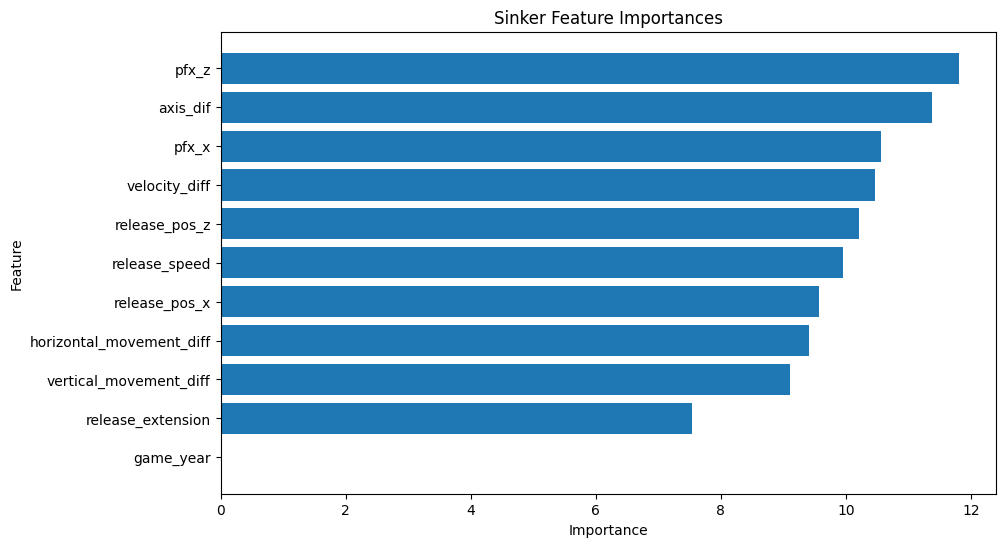

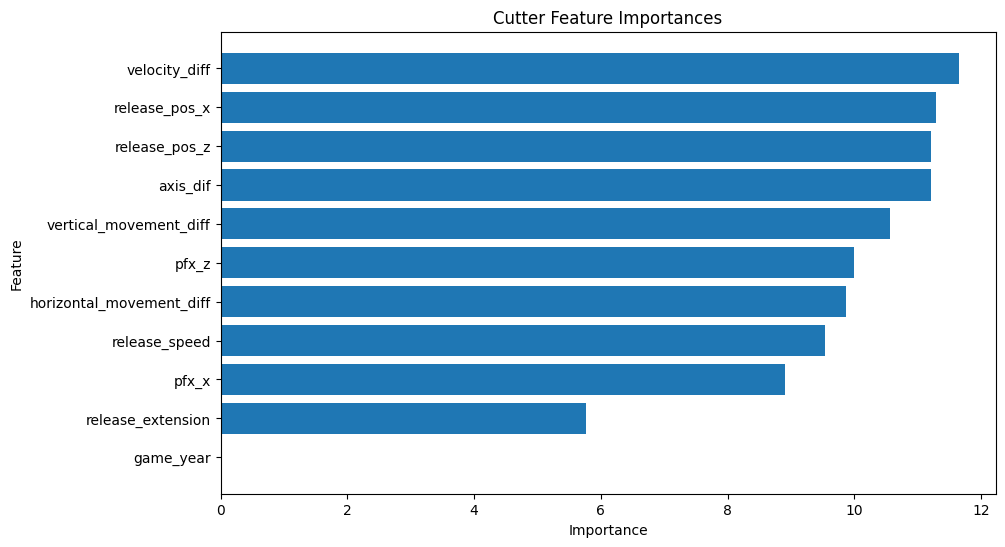

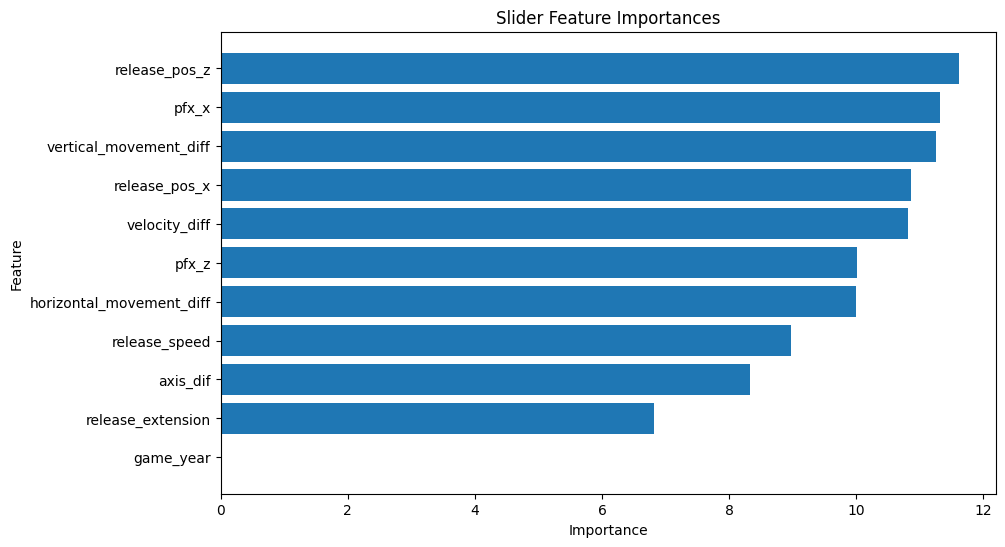

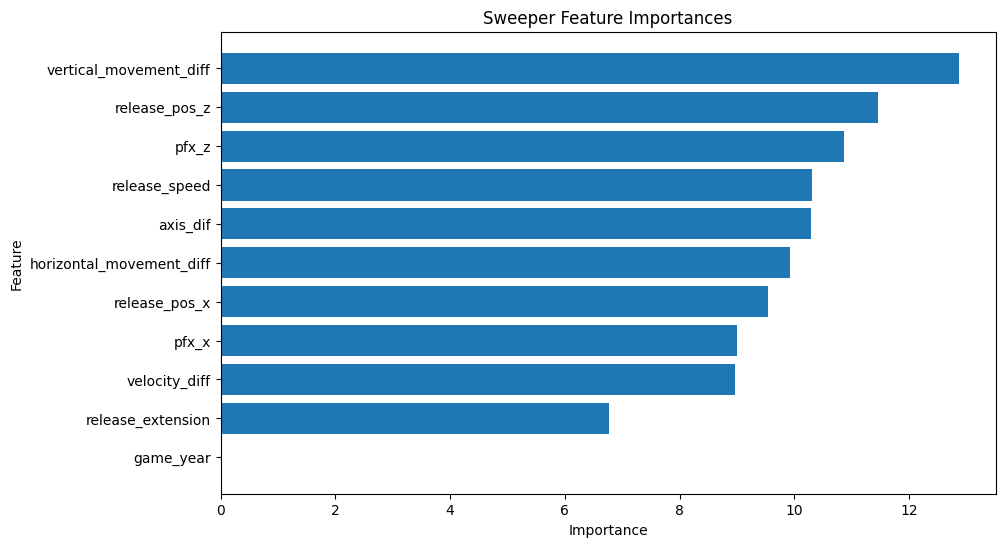

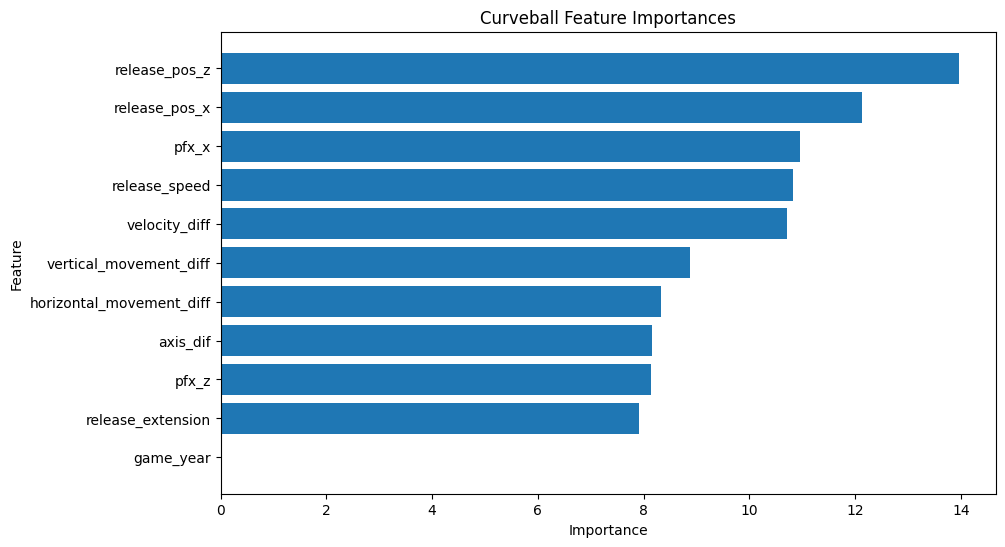

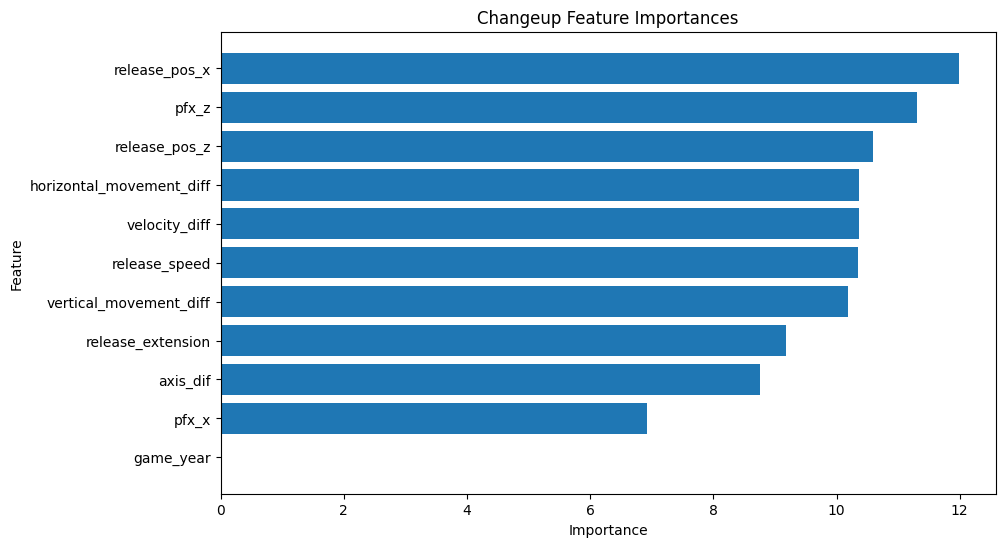

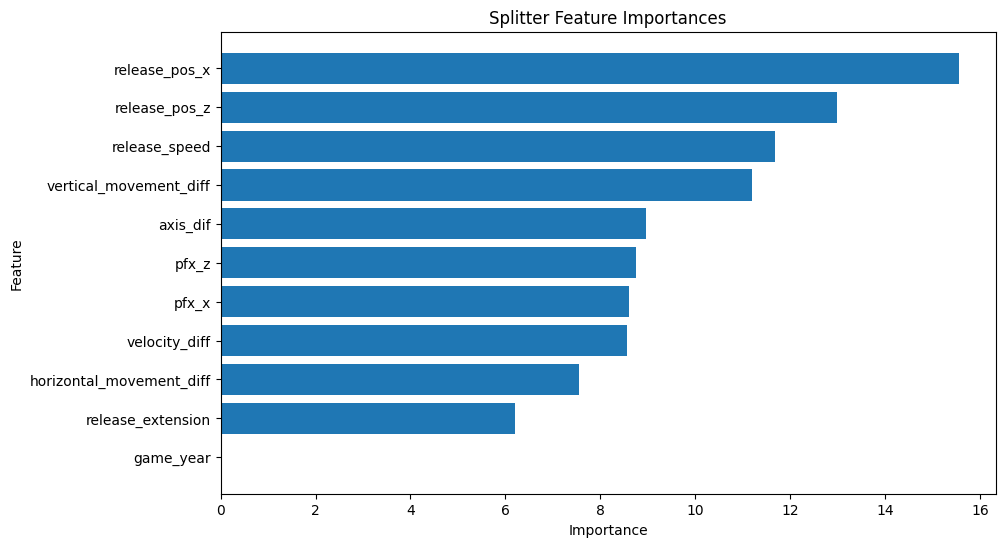

In [38]:
def plot_feature_importances(model, feature_names, title):
    feature_importances = model.get_feature_importance()
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()




plot_feature_importances(fastball_model, features, 'Fastball Feature Importances')
plot_feature_importances(sinker_model, features, 'Sinker Feature Importances')
plot_feature_importances(cutter_model, features, 'Cutter Feature Importances')
plot_feature_importances(slider_model, features, 'Slider Feature Importances')
plot_feature_importances(sweeper_model, features, 'Sweeper Feature Importances')
plot_feature_importances(curveball_model, features, 'Curveball Feature Importances')
plot_feature_importances(changeup_model, features, 'Changeup Feature Importances')
plot_feature_importances(splitter_model, features, 'Splitter Feature Importances')